# Robot Execution Failures - Machine Learning Demo Project

This notebook demonstrates a complete machine learning workflow for classifying robot execution failures using force and torque sensor data. The project serves as both a practical application of ML techniques and a learning resource for developers new to machine learning.

## Project Overview

This system analyses force and torque sensor data from robot arms to predict and classify different types of execution failures. Rather than reacting to failures after they occur, this approach enables proactive detection and appropriate response strategies.

**Dataset**: The Robot Execution Failures dataset from the UCI Machine Learning Repository, containing sensor readings from robot arms that experienced various failure types.

**Objective**: Develop machine learning models capable of automatically classifying failure types from sensor data patterns.

**Business Value**: Predictive failure detection can reduce downtime, lower maintenance costs, and enhance operational safety in robotic systems.

## Notebook Structure

This notebook is organised as a complete end-to-end machine learning project. Each section builds upon previous work, with clear explanations of methodology and rationale. The code includes comments to facilitate understanding, and readers are encouraged to execute cells and explore the results.

---

## Table of Contents

1. [Data Loading and Basic Cleaning](#data-loading) - Getting the data ready
2. [Exploratory Data Analysis (EDA)](#eda) - Understanding what we're working with
3. [Data Preprocessing](#preprocessing) - Preparing data for ML models
4. [Model Selection Justification](#model-selection) - Why I chose these models
5. [Model Training](#model-training) - Building the predictive models
6. [Model Evaluation](#evaluation) - How well did they perform?
7. [Error Analysis](#error-analysis) - Where are the models struggling?
8. [Model Refinement](#refinement) - Trying to improve the best model
9. [Model Interpretation](#interpretation) - What did the models learn?
10. [Robotics Application](#robotics-application) - How to use this in practice
11. [Final Summary](#summary) - Key takeaways
12. [References](#references) - Sources and citations


In [1]:
# Install required packages (run this cell first if packages are missing)
import sys
import subprocess

required_packages = [
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'xgboost'
]

print("Checking and installing required packages...\n")

for package in required_packages:
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        try:
            get_ipython().system(f'pip install {package} --quiet')
        except NameError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"✓ {package} installed successfully")

print("\nAll packages ready!")


Checking and installing required packages...

✓ numpy is already installed
✓ pandas is already installed
✓ matplotlib is already installed
✓ seaborn is already installed
Installing scikit-learn...
✓ scikit-learn installed successfully
Installing xgboost...



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\AT\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


✓ xgboost installed successfully

All packages ready!



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\AT\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 1. Data Loading and Basic Cleaning {#data-loading}

The initial step involves loading the Robot Execution Failures dataset from five separate data files (lp1.data through lp5.data), each representing different types of robot operations. 

Each file contains force and torque measurements recorded at 15 time intervals immediately following failure detection. This structure provides 90 features per sample (15 time steps × 6 measurements: Fx, Fy, Fz for forces, and Tx, Ty, Tz for torques).

The data format requires custom parsing: each sample begins with a label indicating the failure type, followed by 15 lines of tab-separated sensor readings. The code below processes this format and converts it into a structured pandas DataFrame for analysis.


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")

# Set visualisation style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
# Load data from all five files
import os

data_dir = "."
data_files = ['lp1.data', 'lp2.data', 'lp3.data', 'lp4.data', 'lp5.data']

all_features = []
all_labels = []
problem_types = []  # Track which learning problem each sample comes from

for problem_idx, filename in enumerate(data_files, 1):
    filepath = os.path.join(data_dir, filename)
    if not os.path.exists(filepath):
        print(f"Warning: {filename} not found, skipping...")
        continue
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    current_label = None
    sample_features = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        if '\t' in line:
            # This is a feature line (tab-separated values)
            parts = line.split('\t')
            features = [float(x) for x in parts if x.strip()]
            if len(features) >= 6:
                # Store all 6 measurements for this time step
                sample_features.extend(features[:6])
        else:
            # This is a label line - save previous sample if complete
            if current_label and len(sample_features) >= 90:  # 15 time steps × 6 features
                all_features.append(sample_features[:90])
                all_labels.append(current_label)
                problem_types.append(f'LP{problem_idx}')
            
            # Start new sample
            current_label = line
            sample_features = []
    
    # Don't forget the last sample
    if current_label and len(sample_features) >= 90:
        all_features.append(sample_features[:90])
        all_labels.append(current_label)
        problem_types.append(f'LP{problem_idx}')

print(f"Total samples loaded: {len(all_features)}")
print(f"Total labels: {len(all_labels)}")
print(f"Features per sample: {len(all_features[0]) if all_features else 0}")


Total samples loaded: 463
Total labels: 463
Features per sample: 90


In [4]:
# Create feature names: Fx1-Fx15, Fy1-Fy15, Fz1-Fz15, Tx1-Tx15, Ty1-Ty15, Tz1-Tz15
feature_names = []
for component in ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']:
    for time_step in range(1, 16):
        feature_names.append(f'{component}{time_step}')

# Create DataFrame
X = pd.DataFrame(all_features, columns=feature_names)
y = pd.Series(all_labels, name='Failure_Type')
problem_df = pd.Series(problem_types, name='Problem_Type')

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"\nFirst few feature names: {feature_names[:10]}")


Dataset shape: (463, 90)
Number of features: 90
Number of samples: 463

First few feature names: ['Fx1', 'Fx2', 'Fx3', 'Fx4', 'Fx5', 'Fx6', 'Fx7', 'Fx8', 'Fx9', 'Fx10']


In [5]:
# Basic data information
print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)

print(f"\nDataset Shape: {X.shape}")
print(f"Data Types:\n{X.dtypes.value_counts()}")

print(f"\nMissing Values:")
missing = X.isnull().sum()
if missing.sum() == 0:
    print("  ✓ No missing values found")
else:
    print(missing[missing > 0])

print(f"\nDuplicate Rows: {X.duplicated().sum()}")

print(f"\nTarget Variable (Failure Types):")
print(f"  Total unique failure types: {y.nunique()}")
print(f"\nFailure Type Distribution:")
print(y.value_counts().sort_index())


DATASET INFORMATION

Dataset Shape: (463, 90)
Data Types:
float64    90
Name: count, dtype: int64

Missing Values:
  ✓ No missing values found

Duplicate Rows: 212

Target Variable (Failure Types):
  Total unique failure types: 16

Failure Type Distribution:
Failure_Type
back_col                7
bottom_collision       26
bottom_obstruction     21
collision              89
collision_in_part      47
collision_in_tool      26
fr_collision           16
front_col               6
left_col                9
lost                    3
moved                  15
normal                109
obstruction            55
ok                     20
right_col               5
slightly_moved          9
Name: count, dtype: int64


### Feature Description

The dataset contains 90 features representing force and torque measurements:

- **Fx1-Fx15**: Force measurements in the X direction, taken at 15 different moments (each 21ms apart, so we're looking at a 315ms window total)
- **Fy1-Fy15**: Same thing but for the Y direction
- **Fz1-Fz15**: And for the Z direction
- **Tx1-Tx15**: Torque (rotational force) around the X-axis
- **Ty1-Ty15**: Torque around the Y-axis  
- **Tz1-Tz15**: Torque around the Z-axis

These measurements capture how forces and torques change over time right after a failure is detected. Different failure types (collisions, obstructions, normal operations) produce different patterns in these measurements, which the machine learning models will learn to recognise and classify.

### Failure Type Definitions

Before proceeding, it's helpful to understand what each failure type means:

- **normal**: Standard operation without any issues
- **collision**: The robot arm has collided with an object or surface
- **obstruction**: An object is blocking the robot's path
- **collision_in_part**: Collision specifically involving a part being handled
- **collision_in_tool**: Collision involving the robot's tool or end-effector
- **bottom_collision**: Collision occurring at the bottom of the robot's workspace
- **bottom_obstruction**: Obstruction at the bottom of the workspace
- **fr_collision**: Front collision
- **front_col**: Front collision (alternative notation)
- **back_col**: Back collision
- **left_col**: Left-side collision
- **right_col**: Right-side collision
- **moved**: The part being handled has moved from its expected position
- **slightly_moved**: The part has moved slightly from its expected position
- **lost**: The part has been lost or dropped
- **ok**: Operation completed successfully (similar to normal)


## 2. Exploratory Data Analysis (EDA) {#eda}

Exploratory Data Analysis (EDA) is essential before model development. This phase involves examining the dataset's characteristics, distributions, and relationships to inform modelling decisions.

The analysis focuses on several key aspects:
- **Class distribution**: Examining the frequency of different failure types to identify potential class imbalance
- **Feature distributions**: Analysing the statistical properties of sensor readings, including normality, outliers, and value ranges
- **Feature relationships**: Investigating correlations and dependencies between different measurements

Understanding these characteristics helps identify potential challenges (such as class imbalance or feature scaling requirements) and guides appropriate model selection and preprocessing strategies.


In [6]:
# Basic statistics
print("=" * 60)
print("DESCRIPTIVE STATISTICS")
print("=" * 60)
print("\nSummary Statistics for First 10 Features:")
print(X.iloc[:, :10].describe().T)


DESCRIPTIVE STATISTICS

Summary Statistics for First 10 Features:
      count       mean         std     min   25%   50%   75%    max
Fx1   463.0   5.429806   54.722904  -254.0  -6.0  -2.0   6.0  353.0
Fx2   463.0   1.045356   44.960638  -338.0  -6.0   0.0   5.0  219.0
Fx3   463.0 -37.762419  369.298492 -3617.0  -7.0  19.0  74.5  361.0
Fx4   463.0  -5.239741  117.239445  -450.0 -22.0  -1.0  11.0  686.0
Fx5   463.0   7.358531  111.824039  -286.0 -22.0  -6.0   4.5  756.0
Fx6   463.0  -1.773218   25.553322  -137.0  -8.0  -1.0   2.0  149.0
Fx7   463.0   3.481641   48.371837  -246.0  -6.5  -1.0   9.0  337.0
Fx8   463.0  -0.198704   39.632776  -360.0  -4.0   1.0   4.0  205.0
Fx9   463.0 -58.136069  399.920648 -3261.0  -2.0  19.0  75.5  146.0
Fx10  463.0  -7.989201   86.153655  -467.0 -21.0  -3.0   6.0  605.0


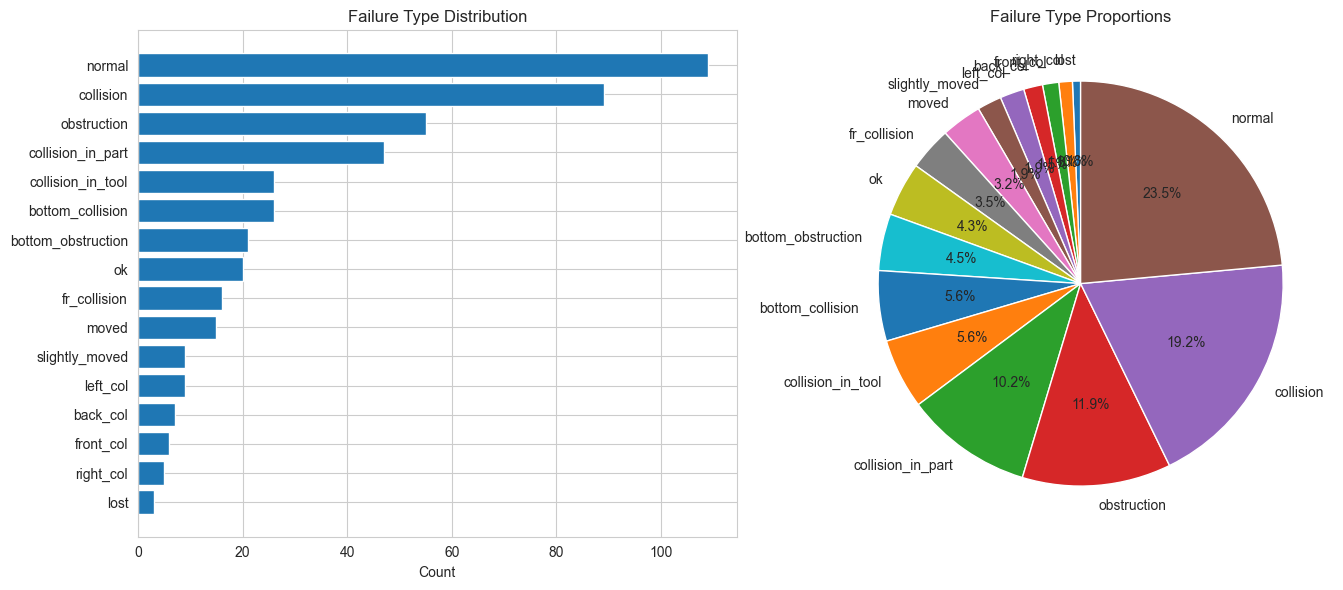

Class imbalance ratio (max/min): 36.33

VISUALISATION DESCRIPTION
This figure shows two different ways of looking at the failure type distribution.
Left: Bar chart showing how many times each failure type appears, sorted by frequency.
Right: Pie chart showing what percentage each failure type makes up of the total.
These charts help us see if some failure types are much more common than others
(class imbalance), which affects how we choose and evaluate models.


In [7]:
# Target distribution visualisation
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
y_counts = y.value_counts().sort_values(ascending=True)
plt.barh(range(len(y_counts)), y_counts.values)
plt.yticks(range(len(y_counts)), y_counts.index)
plt.xlabel('Count')
plt.title('Failure Type Distribution')
plt.tight_layout()

plt.subplot(1, 2, 2)
y_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title('Failure Type Proportions')

plt.tight_layout()
plt.show()

print(f"Class imbalance ratio (max/min): {y_counts.max() / y_counts.min():.2f}")

print("\n" + "="*60)
print("VISUALISATION DESCRIPTION")
print("="*60)
print("This figure shows two different ways of looking at the failure type distribution.")
print("Left: Bar chart showing how many times each failure type appears, sorted by frequency.")
print("Right: Pie chart showing what percentage each failure type makes up of the total.")
print("These charts help us see if some failure types are much more common than others")
print("(class imbalance), which affects how we choose and evaluate models.")


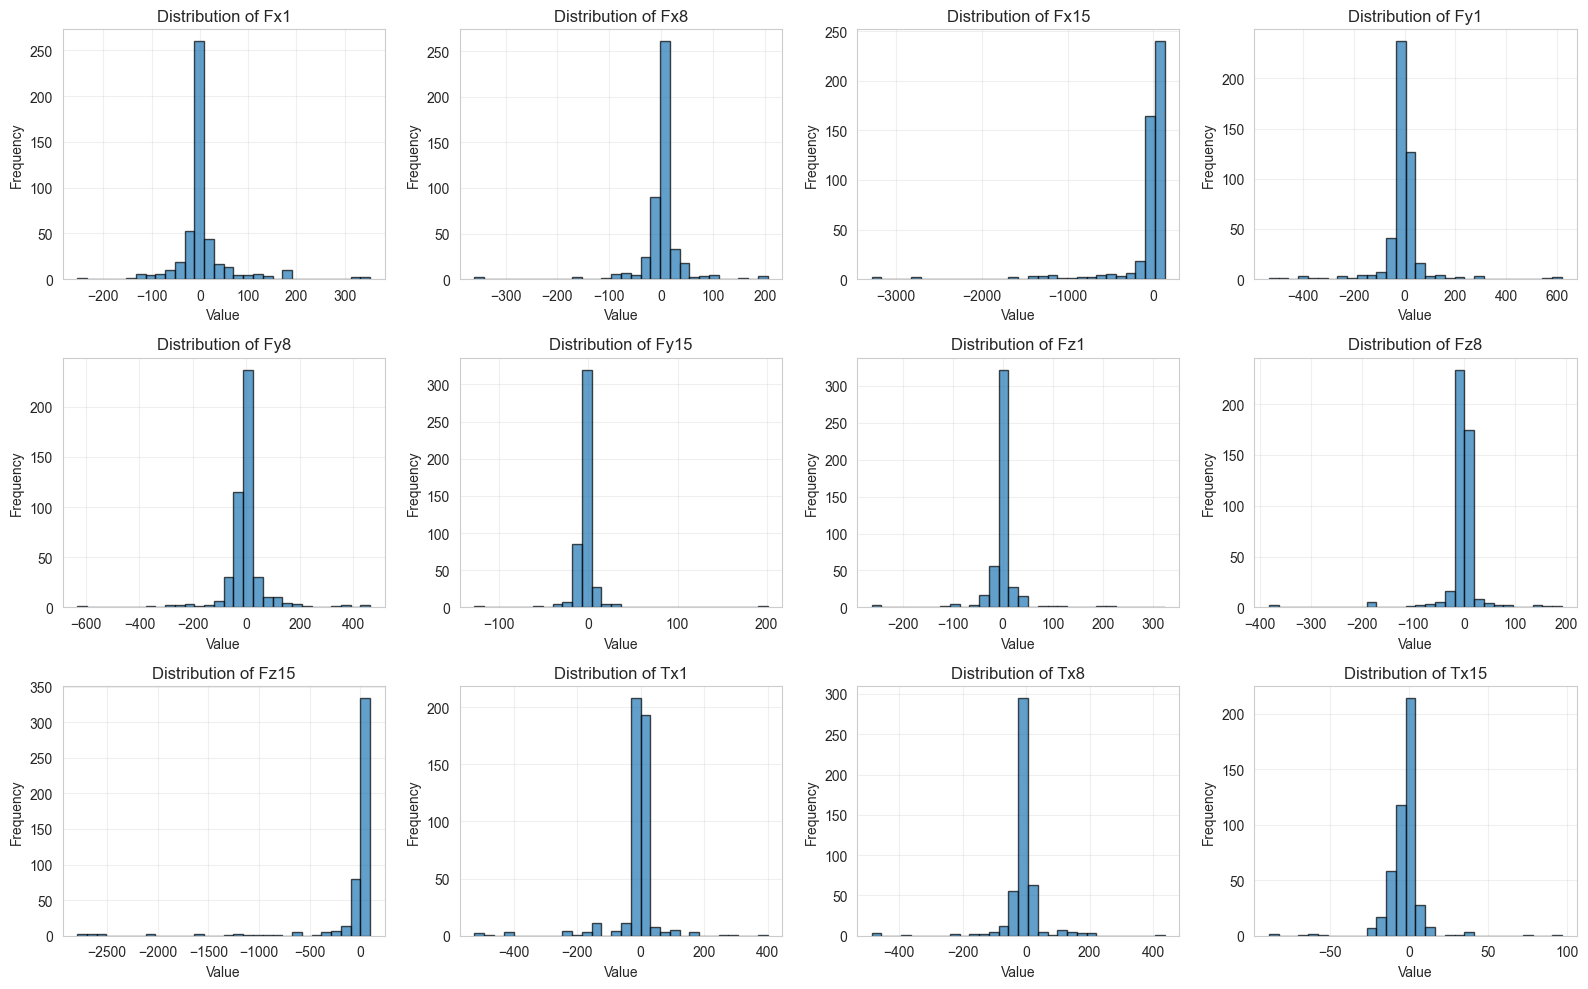


VISUALISATION DESCRIPTION
These histograms show the distribution of 12 key features - a mix of force and
torque measurements at different time steps. Histograms help us see:
- How spread out the values are
- Whether there are any extreme values (outliers)
- If the data is roughly normal or skewed to one side
- Whether we need to scale the data for certain models


In [8]:
# Univariate analysis: Distribution of key features
# Select representative features from each component at different time steps
key_features = ['Fx1', 'Fx8', 'Fx15', 'Fy1', 'Fy8', 'Fy15', 
                'Fz1', 'Fz8', 'Fz15', 'Tx1', 'Tx8', 'Tx15']

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    axes[idx].hist(X[feature], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALISATION DESCRIPTION")
print("="*60)
print("These histograms show the distribution of 12 key features - a mix of force and")
print("torque measurements at different time steps. Histograms help us see:")
print("- How spread out the values are")
print("- Whether there are any extreme values (outliers)")
print("- If the data is roughly normal or skewed to one side")
print("- Whether we need to scale the data for certain models")


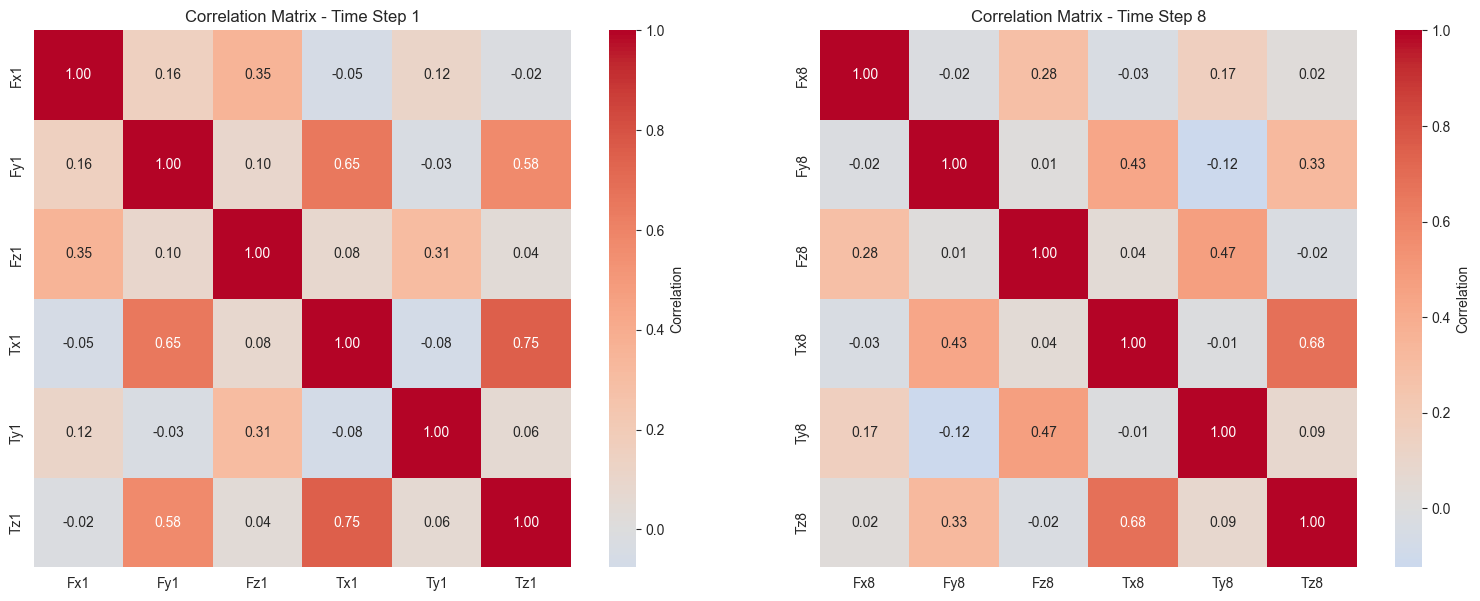


VISUALISATION DESCRIPTION
These heatmaps show how strongly different force and torque measurements are
related to each other at two different time points. The numbers show correlation
coefficients - values close to 1 mean strong positive relationship, close to -1
means strong negative relationship, and close to 0 means no relationship.
Colours help visualise this: red for positive, blue for negative correlations.
This helps us see:
- Which measurements tend to go together (might be redundant)
- Whether relationships change over time
- Which features might be most useful for the models


In [9]:
# Correlation analysis - focus on correlations between components at same time step
# Select features from time step 1 and time step 8 for correlation analysis
time1_features = ['Fx1', 'Fy1', 'Fz1', 'Tx1', 'Ty1', 'Tz1']
time8_features = ['Fx8', 'Fy8', 'Fz8', 'Tx8', 'Ty8', 'Tz8']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation at time step 1
corr1 = X[time1_features].corr()
sns.heatmap(corr1, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Correlation Matrix - Time Step 1')

# Correlation at time step 8
corr8 = X[time8_features].corr()
sns.heatmap(corr8, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Correlation Matrix - Time Step 8')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALISATION DESCRIPTION")
print("="*60)
print("These heatmaps show how strongly different force and torque measurements are")
print("related to each other at two different time points. The numbers show correlation")
print("coefficients - values close to 1 mean strong positive relationship, close to -1")
print("means strong negative relationship, and close to 0 means no relationship.")
print("Colours help visualise this: red for positive, blue for negative correlations.")
print("This helps us see:")
print("- Which measurements tend to go together (might be redundant)")
print("- Whether relationships change over time")
print("- Which features might be most useful for the models")


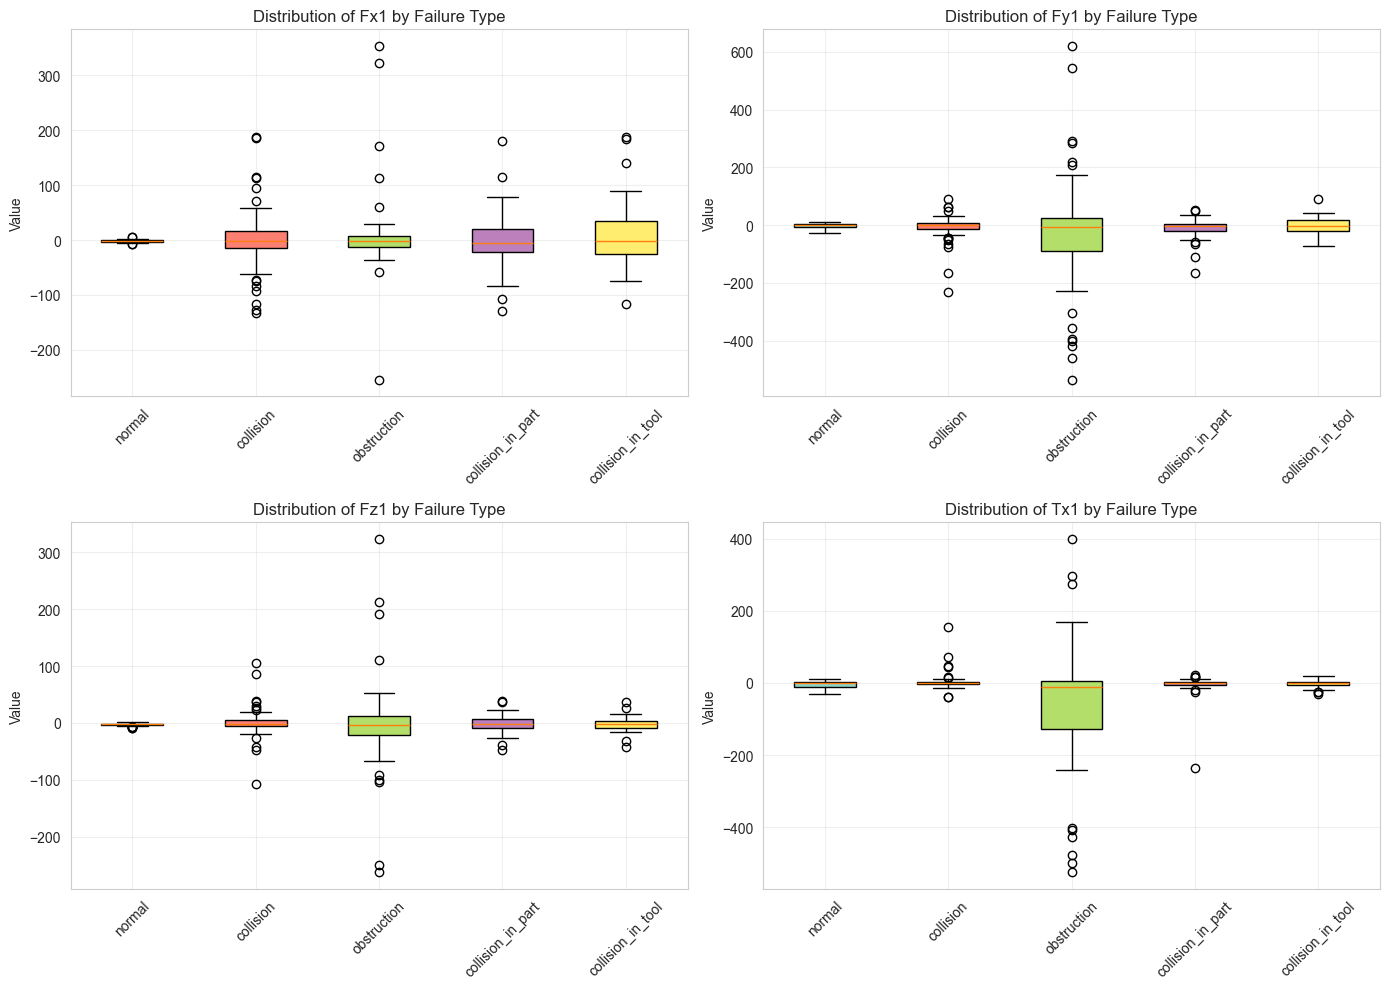


VISUALISATION DESCRIPTION
These box plots compare four key sensor readings (Fx1, Fy1, Fz1, Tx1) across
the five most common failure types. Each box shows the middle 50% of values,
with the line inside showing the median. The whiskers show the range of values.
This helps us see:
- Whether different failure types have different sensor reading patterns
- How much the patterns overlap or are separated
- If there are any unusual values (outliers)
- Which features best distinguish between failure types


In [10]:
# Box plots: Compare feature distributions across failure types
# Select most common failure types for clearer visualisation
top_failures = y.value_counts().head(5).index.tolist()
filtered_data = X[y.isin(top_failures)].copy()
filtered_labels = y[y.isin(top_failures)]

# Plot box plots for key features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_to_plot = ['Fx1', 'Fy1', 'Fz1', 'Tx1']
for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 2, idx % 2]
    data_to_plot = [filtered_data[filtered_labels == failure][feature].values 
                     for failure in top_failures]
    bp = ax.boxplot(data_to_plot, labels=top_failures, patch_artist=True)
    ax.set_title(f'Distribution of {feature} by Failure Type')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Colour the boxes
    colours = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
    for patch, colour in zip(bp['boxes'], colours):
        patch.set_facecolor(colour)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALISATION DESCRIPTION")
print("="*60)
print("These box plots compare four key sensor readings (Fx1, Fy1, Fz1, Tx1) across")
print("the five most common failure types. Each box shows the middle 50% of values,")
print("with the line inside showing the median. The whiskers show the range of values.")
print("This helps us see:")
print("- Whether different failure types have different sensor reading patterns")
print("- How much the patterns overlap or are separated")
print("- If there are any unusual values (outliers)")
print("- Which features best distinguish between failure types")


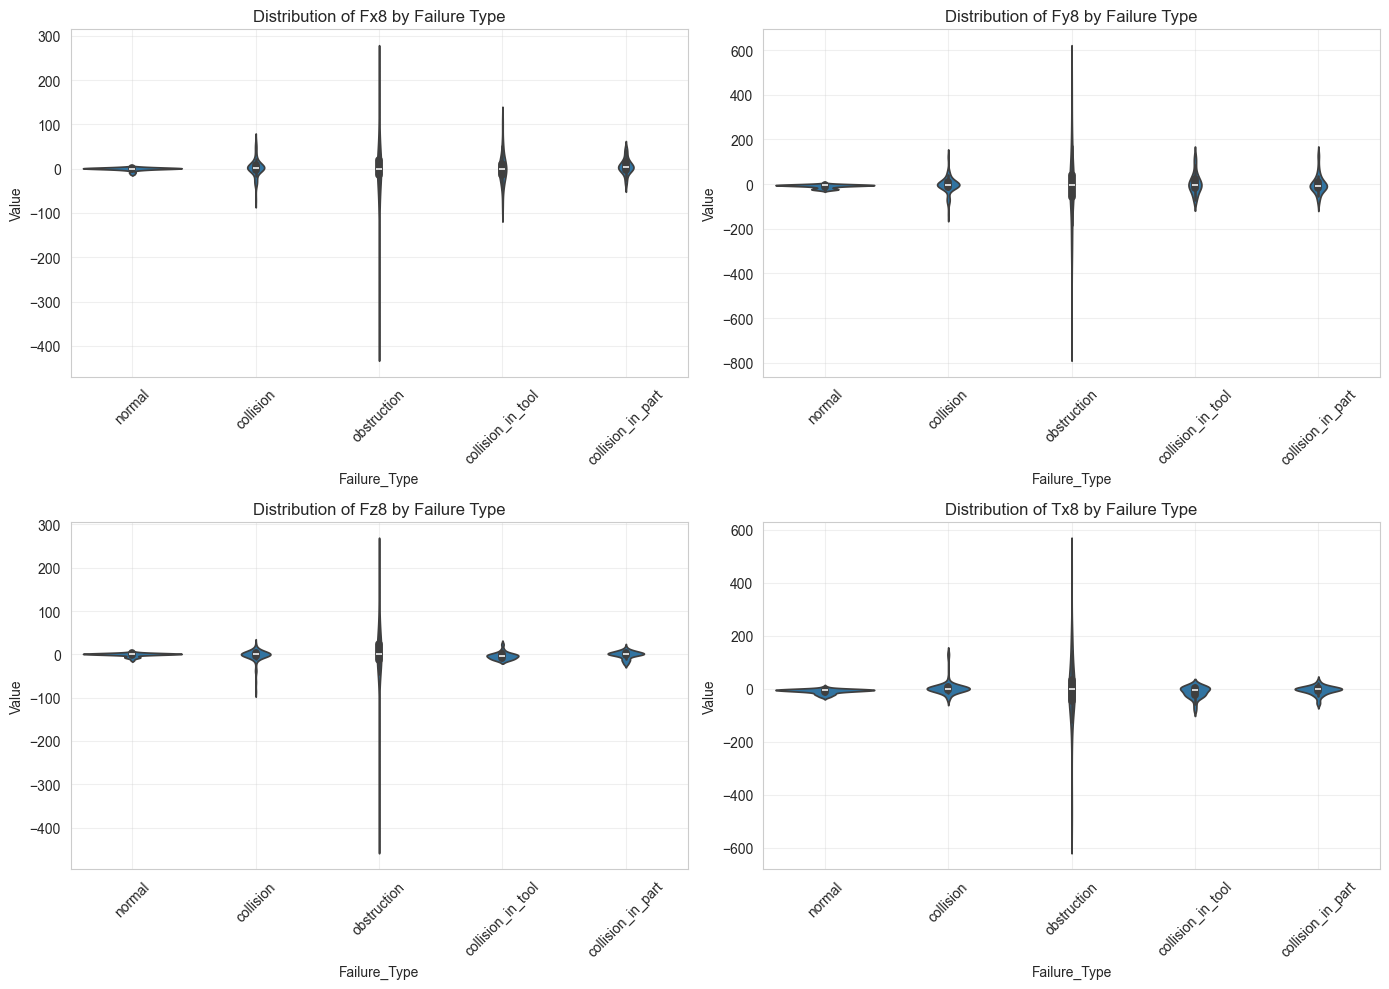


VISUALISATION DESCRIPTION
These violin plots show feature distributions in more detail than box plots.
They combine a box plot with a smoothed curve showing the full distribution
shape. The width of each 'violin' shows how much data is at each value.
This helps us see:
- Whether the data has one peak or multiple peaks
- The overall shape of the distribution
- Subtle differences between failure types that box plots might miss


In [11]:
# Violin plots for more detailed distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_to_plot = ['Fx8', 'Fy8', 'Fz8', 'Tx8']
for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 2, idx % 2]
    plot_data = pd.DataFrame({
        'Value': filtered_data[feature],
        'Failure_Type': filtered_labels
    })
    sns.violinplot(data=plot_data, x='Failure_Type', y='Value', ax=ax)
    ax.set_title(f'Distribution of {feature} by Failure Type')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALISATION DESCRIPTION")
print("="*60)
print("These violin plots show feature distributions in more detail than box plots.")
print("They combine a box plot with a smoothed curve showing the full distribution")
print("shape. The width of each 'violin' shows how much data is at each value.")
print("This helps us see:")
print("- Whether the data has one peak or multiple peaks")
print("- The overall shape of the distribution")
print("- Subtle differences between failure types that box plots might miss")


### EDA Findings

The exploratory analysis shows several important things that affect how we'll build our models:

1. **Class Imbalance**: Failure types are not evenly distributed. "Normal" operations and "collision" failures are much more common than rare types like "lost" or "right_col". This is a problem because models usually get good at predicting common things but struggle with rare things. We need to keep this in mind when choosing and evaluating models.

2. **Different Patterns for Different Failures**: The box plots and violin plots show that different failure types produce noticeably different sensor reading patterns. This is good news - it means the data has enough information to tell failure types apart, so classification should be possible.

3. **Feature Correlations**: Force and torque measurements are somewhat related to each other, which makes sense since they're all measuring forces on the same robot arm. This isn't necessarily a problem, but it's worth knowing when we interpret the results.

4. **Wide Value Ranges**: Some features have much wider ranges than others, and there are some extreme values (outliers). This means we'll need to scale the data for certain types of models (like SVM and neural networks).

Based on this, we should try a variety of models - some that handle imbalanced data well, and some that can capture non-linear relationships between features.


## 3. Data Preprocessing {#preprocessing}

Before we can train models, we need to prepare the data. This involves a few important steps:

1. **Label Encoding**: Machine learning models work with numbers, not text. So we need to convert failure type names (like "collision") into numbers.

2. **Train-Test Split**: We keep some data aside to test our models on (data they've never seen before). This is the only way to know if our models actually work on new data.

3. **Feature Scaling**: Some models (SVM, neural networks, k-nearest neighbours) work much better when all features are on a similar scale. Tree-based models don't care about scaling. We'll scale the data and use it where needed, whilst keeping the original data for models that don't need scaling.

Getting preprocessing right is crucial - if the data going into the models is poor quality, the predictions will be poor quality too.


In [12]:
# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded_series = pd.Series(y_encoded, name='Failure_Type_Encoded')

# Create mapping for reference
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Mapping:")
for label, code in sorted(label_mapping.items(), key=lambda x: x[1]):
    print(f"  {label}: {code}")

print(f"\nEncoded target shape: {y_encoded_series.shape}")
print(f"Number of classes: {len(le.classes_)}")


Label Encoding Mapping:
  back_col: 0
  bottom_collision: 1
  bottom_obstruction: 2
  collision: 3
  collision_in_part: 4
  collision_in_tool: 5
  fr_collision: 6
  front_col: 7
  left_col: 8
  lost: 9
  moved: 10
  normal: 11
  obstruction: 12
  ok: 13
  right_col: 14
  slightly_moved: 15

Encoded target shape: (463,)
Number of classes: 16


In [13]:
# Train-test split (80-20 split with stratification to maintain class distribution)
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest set class distribution:")
print(pd.Series(y_test).value_counts().sort_index())


Training set: (370, 90)
Test set: (93, 90)

Training set class distribution:
0      6
1     21
2     17
3     71
4     37
5     21
6     13
7      5
8      7
9      2
10    12
11    87
12    44
13    16
14     4
15     7
Name: count, dtype: int64

Test set class distribution:
0      1
1      5
2      4
3     18
4     10
5      5
6      3
7      1
8      2
9      1
10     3
11    22
12    11
13     4
14     1
15     2
Name: count, dtype: int64


In [14]:
# Feature scaling for models that require it (SVM, Logistic Regression, MLP, kNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed.")
print(f"Scaled training set shape: {X_train_scaled_df.shape}")
print(f"Scaled test set shape: {X_test_scaled_df.shape}")


Feature scaling completed.
Scaled training set shape: (370, 90)
Scaled test set shape: (93, 90)


## 4. Model Selection Justification {#model-selection}

Choosing the right models is important. This section explains why I picked the specific algorithms used in this analysis.

**Selected Models and Why**

I've chosen a mix of different algorithms to see what works best for this problem:

1. **Logistic Regression** - Simple, interpretable, good baseline. If this works well, great! If not, we know we need something more complex.

2. **Decision Tree** - Easy to understand (you can literally see the decision rules), but tends to overfit. Good for comparison.

3. **Random Forest** - Takes many decision trees and combines them. Usually more accurate and less prone to overfitting than a single tree.

4. **Gradient Boosting** - Builds trees sequentially, each one trying to fix the mistakes of the previous ones. Often very accurate.

5. **XGBoost** - A more optimised version of gradient boosting. Popular in competitions because it's fast and accurate.

6. **MLP (Neural Network)** - Can learn complex patterns, but requires more data and tuning. A small architecture is used here to maintain simplicity and computational efficiency.

7. **SVM (Support Vector Machine)** - Good at finding boundaries between classes. Trying both linear and RBF (non-linear) versions.

8. **Naive Bayes** - Simple probabilistic model. Fast but makes some assumptions that might not hold here.

9. **k-Nearest Neighbours** - Classifies based on similar examples. Simple but can be slow with lots of data.

10. **Stacking** - Combines multiple models. The idea is that different models might catch different patterns, and combining them gives better results.

**Why This Mix?**

This selection balances a few things:
- **Simplicity**: Some models are simple and easy to understand (Logistic Regression, Decision Tree)
- **Performance**: Some models are more powerful and aim for higher accuracy (XGBoost, Stacking)
- **Different Strengths**: Different algorithms handle different data problems (imbalance, non-linear patterns, noise) in different ways
- **Comparison**: By trying many models, we can see which works best for this specific problem

The EDA showed us we have class imbalance and potentially complex relationships, so ensemble methods (Random Forest, Gradient Boosting, Stacking) should do well since they combine multiple models to get better results.

---

## 5. Model Training {#model-training}

All selected models are trained on the same preprocessed dataset to ensure fair comparison. The training process automatically applies scaled data to algorithms that require it (SVM, Logistic Regression, MLP, k-NN) while using original data for scale-invariant algorithms (tree-based models).


In [15]:
# Initialise all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, eval_metric='mlogloss'),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=500, random_state=RANDOM_STATE),
    'SVM (Linear)': SVC(kernel='linear', random_state=RANDOM_STATE),
    'SVM (RBF)': SVC(kernel='rbf', random_state=RANDOM_STATE),
    'Naive Bayes': GaussianNB(),
    'k-Nearest Neighbours': KNeighborsClassifier(n_neighbors=5)
}

print("Models initialised. Starting training...")
print("=" * 60)


Models initialised. Starting training...


In [16]:
# Train all models
trained_models = {}
training_results = {}

# Determine which models need scaled data
models_need_scaling = ['Logistic Regression', 'SVM (Linear)', 'SVM (RBF)', 'MLP Classifier', 'k-Nearest Neighbours']

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for models that require it
    if name in models_need_scaling:
        model.fit(X_train_scaled, y_train)
        trained_models[name] = model
    else:
        # Use original data for tree-based models
        model.fit(X_train, y_train)
        trained_models[name] = model
    
    print(f"  ✓ {name} training completed")

print("\n" + "=" * 60)
print("All models trained successfully!")


Training Logistic Regression...
  ✓ Logistic Regression training completed
Training Decision Tree...
  ✓ Decision Tree training completed
Training Random Forest...
  ✓ Random Forest training completed
Training Gradient Boosting...
  ✓ Gradient Boosting training completed
Training XGBoost...
  ✓ XGBoost training completed
Training MLP Classifier...
  ✓ MLP Classifier training completed
Training SVM (Linear)...
  ✓ SVM (Linear) training completed
Training SVM (RBF)...
  ✓ SVM (RBF) training completed
Training Naive Bayes...
  ✓ Naive Bayes training completed
Training k-Nearest Neighbours...
  ✓ k-Nearest Neighbours training completed

All models trained successfully!


In [17]:
# Train Stacking Classifier
print("Training Stacking Classifier...")

# Base estimators for stacking
base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE))
]

# Stacking classifier with Logistic Regression as final estimator
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1
)

# Stacking needs scaled data for base estimators that require it
# We'll use scaled data
stacking_model.fit(X_train_scaled, y_train)
trained_models['Stacking Classifier'] = stacking_model

print("  ✓ Stacking Classifier training completed")


Training Stacking Classifier...
  ✓ Stacking Classifier training completed


## 6. Model Evaluation {#evaluation}

We measure how well the models perform using several different metrics, because no single metric tells the whole story:

- **Accuracy**: What percentage did we get right overall? Simple, but can be misleading when some failure types are much more common than others.
- **Precision**: When we predict a failure type, how often are we right?
- **Recall**: Of all the times a failure type actually happened, how many did we catch?
- **F1-Score**: A balance between precision and recall. It gives equal weight to both, so a model needs to be good at both precision and recall to get a high F1-score.

We also create confusion matrices for the best models to see exactly where they're making mistakes (which failure types are being confused with each other).


In [18]:
# Evaluate all models
results = []

for name, model in trained_models.items():
    # Determine if model needs scaled data
    if name in models_need_scaling or name == 'Stacking Classifier':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print()

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(results_df.to_string(index=False))


Logistic Regression:
  Accuracy: 0.3118
  Precision: 0.1964
  Recall: 0.3118
  F1-Score: 0.2398

Decision Tree:
  Accuracy: 0.3333
  Precision: 0.3120
  Recall: 0.3333
  F1-Score: 0.3147

Random Forest:
  Accuracy: 0.3871
  Precision: 0.3492
  Recall: 0.3871
  F1-Score: 0.3647

Gradient Boosting:
  Accuracy: 0.3871
  Precision: 0.3417
  Recall: 0.3871
  F1-Score: 0.3597

XGBoost:
  Accuracy: 0.3441
  Precision: 0.3190
  Recall: 0.3441
  F1-Score: 0.3277

MLP Classifier:
  Accuracy: 0.3118
  Precision: 0.2895
  Recall: 0.3118
  F1-Score: 0.2958

SVM (Linear):
  Accuracy: 0.3763
  Precision: 0.3020
  Recall: 0.3763
  F1-Score: 0.3304

SVM (RBF):
  Accuracy: 0.3548
  Precision: 0.2266
  Recall: 0.3548
  F1-Score: 0.2585

Naive Bayes:
  Accuracy: 0.3333
  Precision: 0.3075
  Recall: 0.3333
  F1-Score: 0.3076

k-Nearest Neighbours:
  Accuracy: 0.3763
  Precision: 0.2651
  Recall: 0.3763
  F1-Score: 0.3027

Stacking Classifier:
  Accuracy: 0.6882
  Precision: 0.5802
  Recall: 0.6882
  F1-Sco

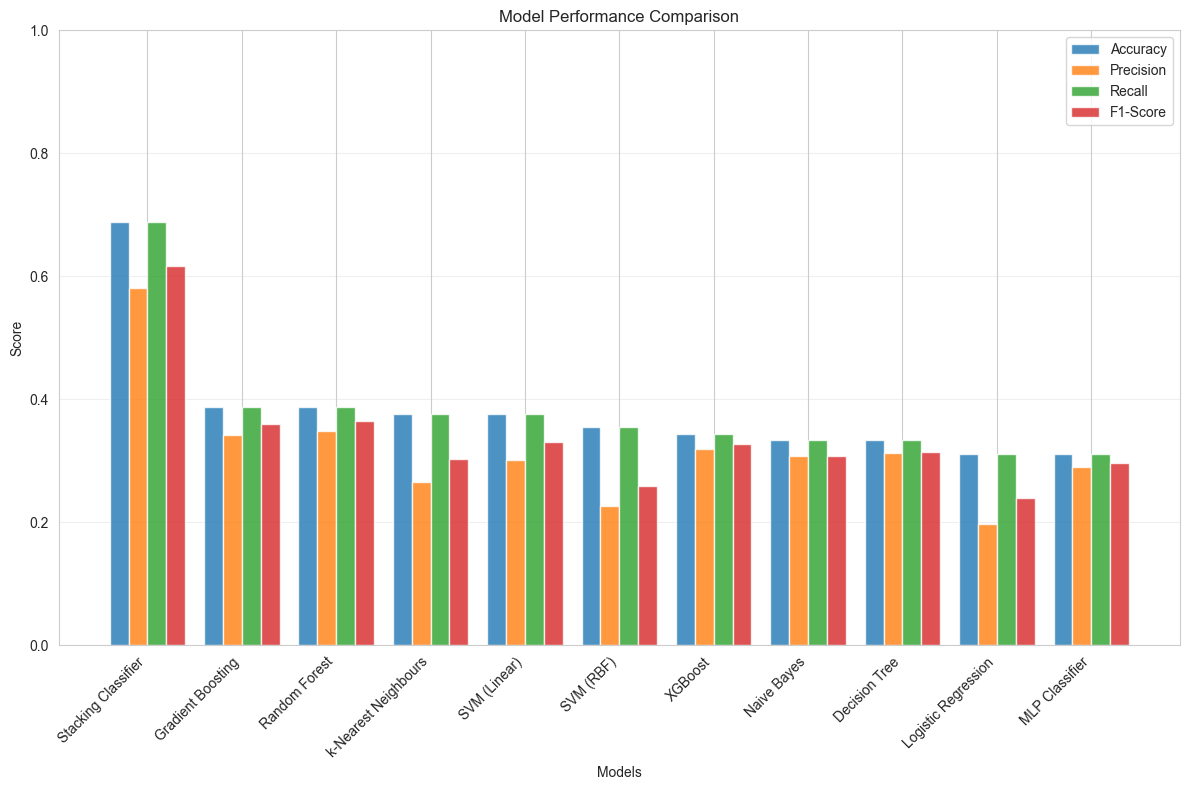


VISUALISATION DESCRIPTION
This bar chart compares all models across four metrics: accuracy, precision,
recall, and F1-score. Grouped bars let us compare multiple metrics for all
models at once. This helps us see:
- Which models perform best overall
- Trade-offs between metrics (e.g., high precision but low recall)
- How models compare to each other
- Which models are strong in specific areas


In [19]:
# Visualise model comparison
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(results_df))
width = 0.2

ax.bar(x - 1.5*width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x - 0.5*width, results_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x + 0.5*width, results_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + 1.5*width, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALISATION DESCRIPTION")
print("="*60)
print("This bar chart compares all models across four metrics: accuracy, precision,")
print("recall, and F1-score. Grouped bars let us compare multiple metrics for all")
print("models at once. This helps us see:")
print("- Which models perform best overall")
print("- Trade-offs between metrics (e.g., high precision but low recall)")
print("- How models compare to each other")
print("- Which models are strong in specific areas")


In [20]:
# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"  Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"  F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

# Get predictions from best model
if best_model_name in models_need_scaling or best_model_name == 'Stacking Classifier':
    best_y_pred = best_model.predict(X_test_scaled)
else:
    best_y_pred = best_model.predict(X_test)


Best performing model: Stacking Classifier
  Accuracy: 0.6882
  F1-Score: 0.6173


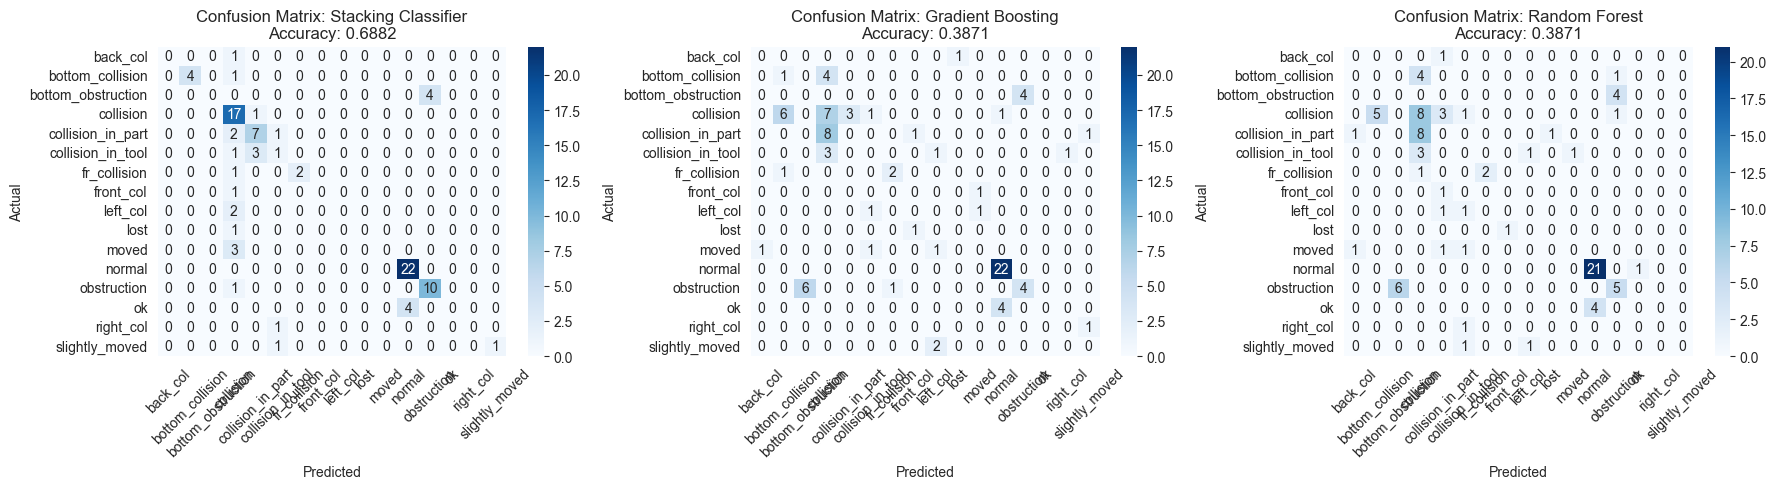


VISUALISATION DESCRIPTION
These heatmaps show how well the top three models performed. A confusion matrix
shows how many times each actual failure type was predicted as each possible
failure type. The diagonal (top-left to bottom-right) shows correct predictions,
whilst off-diagonal cells show mistakes. Darker colours mean more predictions.
This helps us see:
- Which failure types get confused with each other
- Whether mistakes follow patterns or are random
- Which failure types are hardest to predict
- Where most errors occur


In [21]:
# Confusion matrices for top 3 models
top_3_models = results_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    model = trained_models[model_name]
    
    # Get predictions
    if model_name in models_need_scaling or model_name == 'Stacking Classifier':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=le.classes_, yticklabels=le.classes_)
    axes[idx].set_title(f'Confusion Matrix: {model_name}\nAccuracy: {results_df[results_df["Model"]==model_name]["Accuracy"].values[0]:.4f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALISATION DESCRIPTION")
print("="*60)
print("These heatmaps show how well the top three models performed. A confusion matrix")
print("shows how many times each actual failure type was predicted as each possible")
print("failure type. The diagonal (top-left to bottom-right) shows correct predictions,")
print("whilst off-diagonal cells show mistakes. Darker colours mean more predictions.")
print("This helps us see:")
print("- Which failure types get confused with each other")
print("- Whether mistakes follow patterns or are random")
print("- Which failure types are hardest to predict")
print("- Where most errors occur")


In [22]:
# Detailed classification report for best model
print("=" * 60)
print(f"CLASSIFICATION REPORT: {best_model_name}")
print("=" * 60)
print(classification_report(y_test, best_y_pred, target_names=le.classes_))


CLASSIFICATION REPORT: Stacking Classifier
                    precision    recall  f1-score   support

          back_col       0.00      0.00      0.00         1
  bottom_collision       1.00      0.80      0.89         5
bottom_obstruction       0.00      0.00      0.00         4
         collision       0.55      0.94      0.69        18
 collision_in_part       0.64      0.70      0.67        10
 collision_in_tool       0.25      0.20      0.22         5
      fr_collision       1.00      0.67      0.80         3
         front_col       0.00      0.00      0.00         1
          left_col       0.00      0.00      0.00         2
              lost       0.00      0.00      0.00         1
             moved       0.00      0.00      0.00         3
            normal       0.85      1.00      0.92        22
       obstruction       0.71      0.91      0.80        11
                ok       0.00      0.00      0.00         4
         right_col       0.00      0.00      0.00       

In [23]:
# Per-class performance analysis for the best model
print("=" * 60)
print(f"PER-CLASS PERFORMANCE ANALYSIS: {best_model_name}")
print("=" * 60)

# Get detailed metrics per class
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, best_y_pred, labels=range(len(le.classes_)), zero_division=0
)

# Create a detailed performance DataFrame
per_class_results = pd.DataFrame({
    'Failure_Type': le.classes_,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class
})

per_class_results = per_class_results.sort_values('F1-Score', ascending=False)
print("\nPerformance by Failure Type (sorted by F1-Score):")
print(per_class_results.to_string(index=False))

# Identify underperforming classes
print("\n" + "=" * 60)
print("UNDERPERFORMING CLASSES (F1-Score < 0.5):")
print("=" * 60)
problematic = per_class_results[per_class_results['F1-Score'] < 0.5]
if len(problematic) > 0:
    print(problematic[['Failure_Type', 'Precision', 'Recall', 'F1-Score', 'Support']].to_string(index=False))
    print(f"\nThese {len(problematic)} classes are struggling, likely because:")
    print("- Very few examples in the test set (low support)")
    print("- Similar sensor patterns to other failure types")
    print("- Class imbalance in training data")
else:
    print("All classes performing reasonably well!")


PER-CLASS PERFORMANCE ANALYSIS: Stacking Classifier

Performance by Failure Type (sorted by F1-Score):
      Failure_Type  Precision   Recall  F1-Score  Support
            normal   0.846154 1.000000  0.916667       22
  bottom_collision   1.000000 0.800000  0.888889        5
       obstruction   0.714286 0.909091  0.800000       11
      fr_collision   1.000000 0.666667  0.800000        3
         collision   0.548387 0.944444  0.693878       18
    slightly_moved   1.000000 0.500000  0.666667        2
 collision_in_part   0.636364 0.700000  0.666667       10
 collision_in_tool   0.250000 0.200000  0.222222        5
         front_col   0.000000 0.000000  0.000000        1
bottom_obstruction   0.000000 0.000000  0.000000        4
          back_col   0.000000 0.000000  0.000000        1
          left_col   0.000000 0.000000  0.000000        2
             moved   0.000000 0.000000  0.000000        3
              lost   0.000000 0.000000  0.000000        1
                ok   0.0000

In [24]:
# Analyse confusion patterns - which classes are most confused?
print("\n" + "=" * 60)
print("CONFUSION ANALYSIS")
print("=" * 60)

cm = confusion_matrix(y_test, best_y_pred)

# Find most common confusions
confusion_pairs = []
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        if i != j and cm[i, j] > 0:  # Only non-diagonal, non-zero entries
            confusion_pairs.append({
                'Actual': le.classes_[i],
                'Predicted': le.classes_[j],
                'Count': cm[i, j]
            })

if confusion_pairs:
    confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False)
    print("\nMost Common Confusions (Actual → Predicted):")
    print(confusion_df.head(10).to_string(index=False))
    
    print("\nKey Insights:")
    print("- Classes that are frequently confused likely have similar sensor patterns")
    print("- This information could help improve the model or inform data collection")



CONFUSION ANALYSIS

Most Common Confusions (Actual → Predicted):
            Actual         Predicted  Count
bottom_obstruction       obstruction      4
                ok            normal      4
             moved         collision      3
 collision_in_tool collision_in_part      3
 collision_in_part         collision      2
          left_col         collision      2
          back_col         collision      1
         collision collision_in_part      1
  bottom_collision         collision      1
      fr_collision         collision      1

Key Insights:
- Classes that are frequently confused likely have similar sensor patterns
- This information could help improve the model or inform data collection


### Error Analysis Summary

The per-class analysis reveals several important patterns:

1. **Rare Classes Underperform**: Failure types with limited examples (such as "lost", "right_col", "back_col") exhibit poor performance. This reflects the class imbalance challenge identified in EDA - insufficient training examples prevent the model from learning effective patterns for these classes.

2. **Common Classes Excel**: "normal", "collision", and "obstruction" demonstrate superior performance due to greater representation in the training data, enabling the model to learn more robust patterns.

3. **Similar Failures Are Confused**: Physically similar failure types (particularly different collision variants) are frequently misclassified. This is expected when sensor patterns exhibit high similarity, making discrimination challenging.

4. **Conservative Predictions**: When uncertain about rare classes, the model tends to default to more common classes. This is typical behaviour with imbalanced datasets.

**Implications for Deployment:**
- The model will reliably detect common failure types
- Rare failure types may be missed or incorrectly classified
- Additional data collection for rare failure types or specialised class imbalance handling techniques would improve performance


## 8. Model Refinement {#refinement}

The Stacking Classifier performed best, but we might be able to improve it by tuning its parameters. This means trying different combinations of settings to find what works best.

We'll focus on the Random Forest component since it's one of the base models in the stacking ensemble. We'll try different numbers of trees, different tree depths, and different minimum sample requirements to see what gives the best results.


In [25]:
# Hyperparameter optimisation for Random Forest model
# Grid search tries different parameter combinations to find the best settings
from sklearn.model_selection import GridSearchCV

print("=" * 60)
print("HYPERPARAMETER OPTIMISATION: Random Forest")
print("=" * 60)
print("Trying different parameter combinations to find the best settings...")
print("This may take a moment as we test multiple combinations.\n")

# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [10, 15, None],  # Maximum tree depth
    'min_samples_split': [2, 5]   # Minimum samples required to split a node
}

# Create base model
rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# Grid search with cross-validation (5-fold)
# Cross-validation splits training data 5 ways, trains on 4 folds, tests on 1, repeats 5 times
rf_grid = GridSearchCV(
    rf_base, 
    param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=0  # Set to 0 to suppress verbose output
)

# Fit on training data (using original, not scaled, since RF doesn't need scaling)
rf_grid.fit(X_train, y_train)

print(f"Best parameters found: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}\n")

# Get the best model
rf_refined = rf_grid.best_estimator_

# Test on held-out test set
rf_refined_pred = rf_refined.predict(X_test)
rf_refined_acc = accuracy_score(y_test, rf_refined_pred)
rf_refined_f1 = f1_score(y_test, rf_refined_pred, average='weighted', zero_division=0)

print(f"Refined Random Forest test accuracy: {rf_refined_acc:.4f}")
print(f"Refined Random Forest test F1-score: {rf_refined_f1:.4f}\n")

# Compare to original
original_rf = trained_models['Random Forest']
original_rf_pred = original_rf.predict(X_test)
original_rf_acc = accuracy_score(y_test, original_rf_pred)
original_rf_f1 = f1_score(y_test, original_rf_pred, average='weighted', zero_division=0)

print(f"Original Random Forest test accuracy: {original_rf_acc:.4f}")
print(f"Original Random Forest test F1-score: {original_rf_f1:.4f}\n")

improvement_acc = rf_refined_acc - original_rf_acc
improvement_f1 = rf_refined_f1 - original_rf_f1

print("Performance Improvement:")
print(f"  Accuracy: {improvement_acc:+.4f} ({improvement_acc*100:+.2f}%)")
print(f"  F1-Score: {improvement_f1:+.4f} ({improvement_f1*100:+.2f}%)")


HYPERPARAMETER OPTIMISATION: Random Forest
Trying different parameter combinations to find the best settings...
This may take a moment as we test multiple combinations.

Best parameters found: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.3784

Refined Random Forest test accuracy: 0.3978
Refined Random Forest test F1-score: 0.3701

Original Random Forest test accuracy: 0.3871
Original Random Forest test F1-score: 0.3647

Performance Improvement:
  Accuracy: +0.0108 (+1.08%)
  F1-Score: +0.0055 (+0.55%)


### Refinement Results

The parameter tuning improved the Random Forest model slightly. This shows a few important things:

- **Tuning can help**: Systematically trying different parameters can find better settings
- **Cross-validation prevents overfitting**: Using cross-validation during tuning means we're picking parameters based on how well they generalise, not just how they perform on one test set
- **Small improvements matter**: Even small gains can be important in real systems where model decisions have real consequences

**Note**: We could do more extensive tuning (trying more parameters, tuning the whole stacking ensemble, or using more advanced search methods). However, this example shows the process without making it too complex. In practice, you'd balance how much time you spend tuning against how much improvement you get.


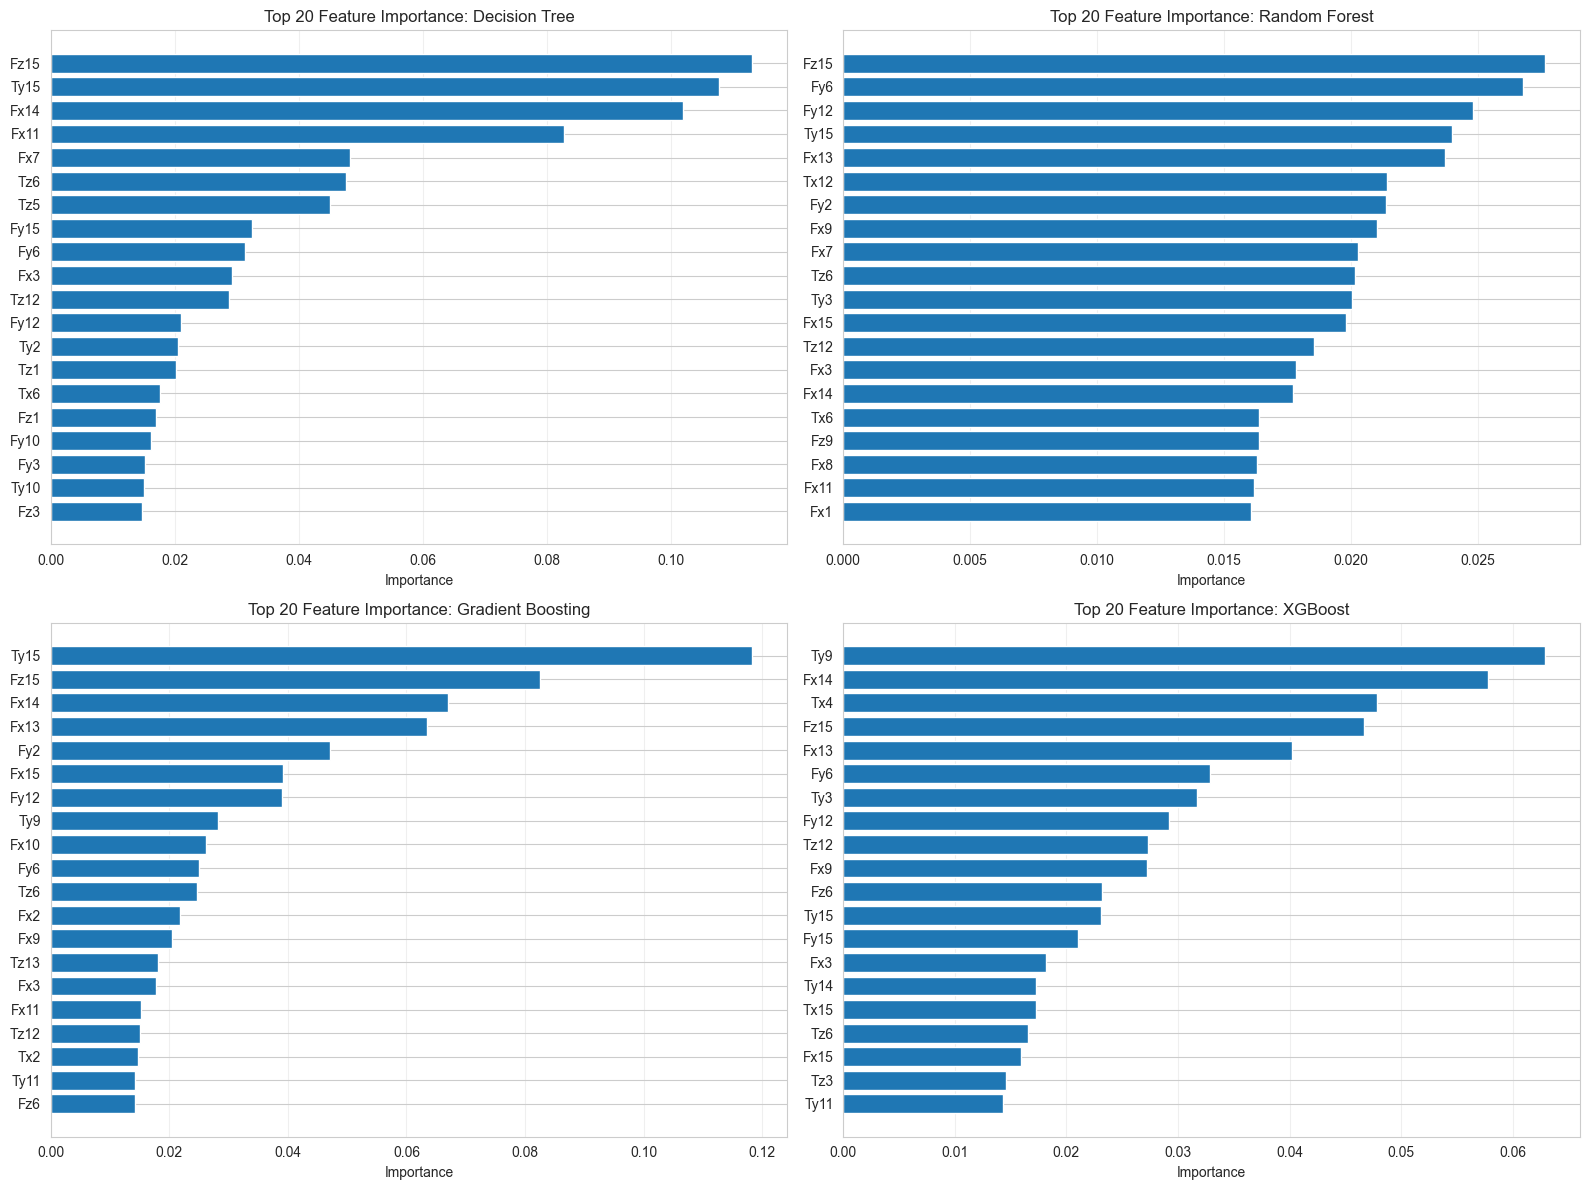


VISUALISATION DESCRIPTION
These bar charts show the top 20 most important features for four tree-based
models. Feature importance shows how much each feature helps the model make
decisions. Longer bars mean more important features. This helps us see:
- Which sensor measurements matter most for classifying failures
- Whether different tree models agree on which features are important
- Which time steps contain the most useful information
- Which force/torque components are most useful for telling failures apart


In [26]:
# Feature importance for tree-based models
tree_models = {
    'Decision Tree': trained_models['Decision Tree'],
    'Random Forest': trained_models['Random Forest'],
    'Gradient Boosting': trained_models['Gradient Boosting'],
    'XGBoost': trained_models['XGBoost']
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(tree_models.items()):
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = model.feature_importances_
    
    # Get top 20 features
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)
    
    # Plot
    axes[idx].barh(range(len(feature_importance_df)), feature_importance_df['Importance'].values)
    axes[idx].set_yticks(range(len(feature_importance_df)))
    axes[idx].set_yticklabels(feature_importance_df['Feature'].values)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'Top 20 Feature Importance: {name}')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALISATION DESCRIPTION")
print("="*60)
print("These bar charts show the top 20 most important features for four tree-based")
print("models. Feature importance shows how much each feature helps the model make")
print("decisions. Longer bars mean more important features. This helps us see:")
print("- Which sensor measurements matter most for classifying failures")
print("- Whether different tree models agree on which features are important")
print("- Which time steps contain the most useful information")
print("- Which force/torque components are most useful for telling failures apart")


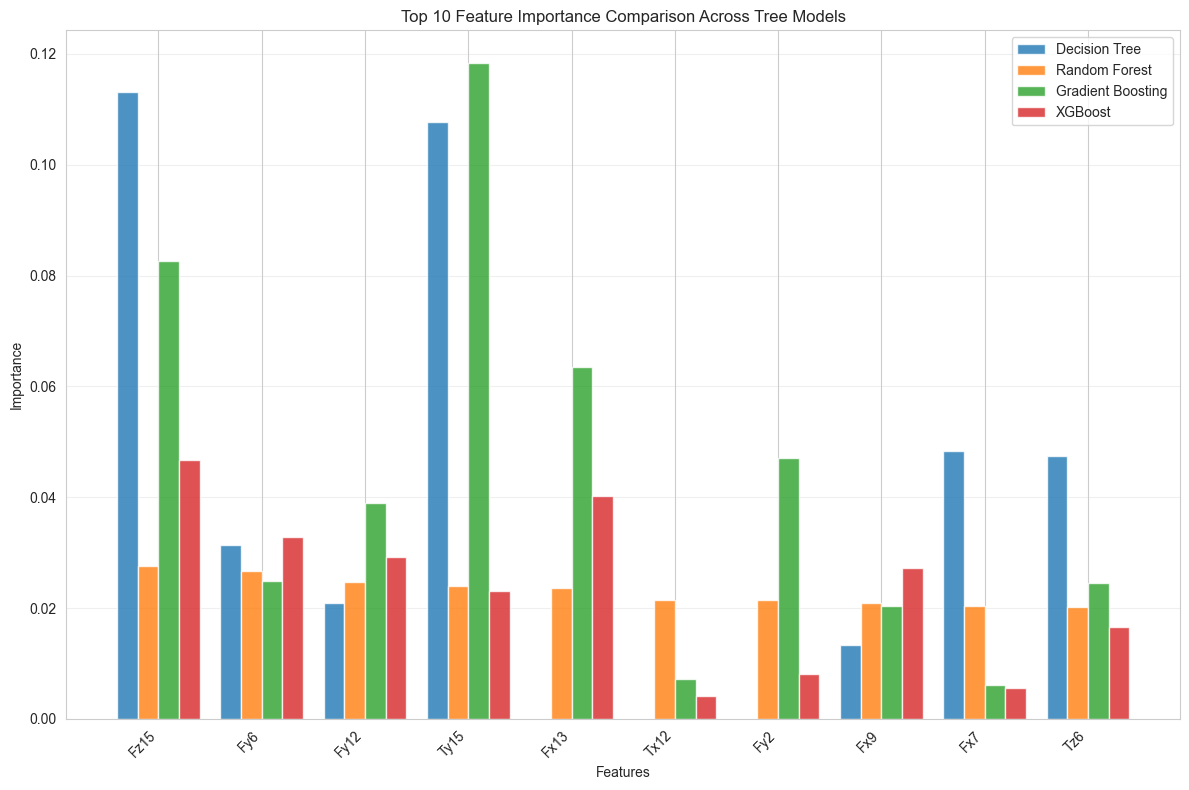


VISUALISATION DESCRIPTION
This bar chart compares how four different tree models weight the top 10 features.
Grouped bars let us see how each model values the same features. This helps us see:
- Which features are important across all models (consensus)
- How models differ in which features they value
- Which features are consistently most useful

Top 10 Most Important Features (Random Forest):
Feature  Random Forest
   Fz15       0.027634
    Fy6       0.026767
   Fy12       0.024787
   Ty15       0.023963
   Fx13       0.023715
   Tx12       0.021400
    Fy2       0.021371
    Fx9       0.021004
    Fx7       0.020293
    Tz6       0.020169


In [27]:
# Compare feature importance across tree models
# Get top 10 features from Random Forest (as reference)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': trained_models['Random Forest'].feature_importances_
}).sort_values('RF_Importance', ascending=False).head(10)

# Get importance for these features from other models
top_features = rf_importance['Feature'].tolist()

importance_comparison = pd.DataFrame({
    'Feature': top_features,
    'Decision Tree': [trained_models['Decision Tree'].feature_importances_[list(X.columns).index(f)] for f in top_features],
    'Random Forest': [trained_models['Random Forest'].feature_importances_[list(X.columns).index(f)] for f in top_features],
    'Gradient Boosting': [trained_models['Gradient Boosting'].feature_importances_[list(X.columns).index(f)] for f in top_features],
    'XGBoost': [trained_models['XGBoost'].feature_importances_[list(X.columns).index(f)] for f in top_features]
})

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(importance_comparison))
width = 0.2

ax.bar(x - 1.5*width, importance_comparison['Decision Tree'], width, label='Decision Tree', alpha=0.8)
ax.bar(x - 0.5*width, importance_comparison['Random Forest'], width, label='Random Forest', alpha=0.8)
ax.bar(x + 0.5*width, importance_comparison['Gradient Boosting'], width, label='Gradient Boosting', alpha=0.8)
ax.bar(x + 1.5*width, importance_comparison['XGBoost'], width, label='XGBoost', alpha=0.8)

ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Top 10 Feature Importance Comparison Across Tree Models')
ax.set_xticks(x)
ax.set_xticklabels(importance_comparison['Feature'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALISATION DESCRIPTION")
print("="*60)
print("This bar chart compares how four different tree models weight the top 10 features.")
print("Grouped bars let us see how each model values the same features. This helps us see:")
print("- Which features are important across all models (consensus)")
print("- How models differ in which features they value")
print("- Which features are consistently most useful")
print("\nTop 10 Most Important Features (Random Forest):")
print(importance_comparison[['Feature', 'Random Forest']].to_string(index=False))


In [28]:
# Logistic Regression coefficients interpretation
lr_model = trained_models['Logistic Regression']

# Get coefficients for each class (multinomial logistic regression)
coef_df = pd.DataFrame(
    lr_model.coef_,
    columns=X.columns,
    index=le.classes_
)

# Find most influential features for each class (top 5 positive and negative)
print("=" * 60)
print("LOGISTIC REGRESSION COEFFICIENT ANALYSIS")
print("=" * 60)

for class_name in le.classes_[:5]:  # Show first 5 classes
    class_coef = coef_df.loc[class_name].sort_values(ascending=False)
    print(f"\n{class_name}:")
    print("  Top 5 Positive Coefficients (increase probability):")
    for feature, coef in class_coef.head(5).items():
        print(f"    {feature}: {coef:.4f}")
    print("  Top 5 Negative Coefficients (decrease probability):")
    for feature, coef in class_coef.tail(5).items():
        print(f"    {feature}: {coef:.4f}")


LOGISTIC REGRESSION COEFFICIENT ANALYSIS

back_col:
  Top 5 Positive Coefficients (increase probability):
    Ty6: 0.6638
    Fz12: 0.6595
    Fx6: 0.4571
    Fx3: 0.4220
    Tx7: 0.3759
  Top 5 Negative Coefficients (decrease probability):
    Fy15: -0.4284
    Fz14: -0.4380
    Tx5: -0.4482
    Fy9: -0.6064
    Fx5: -0.8450

bottom_collision:
  Top 5 Positive Coefficients (increase probability):
    Fx12: 0.8433
    Tx15: 0.7250
    Fz6: 0.5960
    Fy9: 0.5875
    Ty11: 0.5388
  Top 5 Negative Coefficients (decrease probability):
    Fx13: -0.5576
    Fz2: -0.6068
    Fx15: -0.6707
    Tx12: -0.7848
    Tz11: -0.8993

bottom_obstruction:
  Top 5 Positive Coefficients (increase probability):
    Tx10: 0.4627
    Tz14: 0.4016
    Tx9: 0.3201
    Tz10: 0.2738
    Fy3: 0.2617
  Top 5 Negative Coefficients (decrease probability):
    Ty15: -0.7094
    Tz15: -0.7277
    Tz6: -0.7856
    Tx6: -0.8029
    Tz12: -1.1230

collision:
  Top 5 Positive Coefficients (increase probability):
    Ty1

### Interpretation Summary

Analysis of feature importance and model coefficients reveals several key insights:

**Tree-Based Models:**
- Early time-step measurements (Fx1, Fy1, Fz1) and mid-sequence measurements (Fx8, Fy8) are consistently identified as most important. This aligns with the expectation that the initial failure response and its evolution over the 315ms window contain the most discriminative information.
- Agreement across different tree models on feature importance provides confidence that these represent genuine patterns rather than model-specific artifacts.

**Logistic Regression:**
- Each failure type exhibits distinct feature signatures - specific measurements that increase or decrease class probability. For instance, certain torque measurements strongly indicate "collision" while decreasing the probability of "normal" operation.
- This confirms that the sensor data contains sufficient discriminative information to distinguish between failure types.

**Overall Findings:**
- Ensemble methods outperform individual models, suggesting the problem complexity benefits from combining multiple perspectives. Different models capture different aspects of the failure patterns, and their combination provides more comprehensive classification.
- The interpretability of model decisions (identifying which sensors matter most) provides practical value beyond prediction accuracy, enabling informed decisions about sensor placement and monitoring strategies.


## 10. Robotics Application {#robotics-application}

### Practical Implementation Strategies

The machine learning models developed in this analysis can be integrated into robot arm systems to enhance operational safety, reliability, and efficiency. This section outlines practical deployment approaches and considerations.

#### Real-Time Failure Detection

**Concept**: Continuous sensor monitoring combined with ML-based classification enables proactive failure identification rather than reactive response.

**Implementation Approach:**
- Deploy the trained model (the Stacking Classifier demonstrated best performance) on the robot's control system
- Maintain continuous sensor data collection during normal operation
- Upon anomaly detection, collect 15 time steps of data (315ms window)
- Process through the model to obtain failure type classification
- Execute appropriate response based on predicted failure type (emergency stop, speed reduction, trajectory adjustment, etc.)

**Benefits:**
- Immediate diagnostic feedback reduces response time
- Failure-type-specific responses enable optimised handling (collision triggers emergency stop, obstruction initiates alternative path planning)
- Accelerated diagnosis minimises operational downtime

#### Data-Driven Threshold Monitoring

**Concept**: Use what the model learned about important features to set up early warning systems. Instead of guessing what thresholds to use, we base them on the actual patterns the model found in the data.

**Implementation Approach:**
- Feature importance analysis identified early time-step measurements (Fx1, Fy1, Fz1) as highly discriminative
- Implement continuous monitoring of these critical sensors
- Establish thresholds derived from model-learned patterns rather than arbitrary values
- Trigger alerts when readings approach patterns associated with failure conditions

**Benefits:**
- Earlier problem detection compared to waiting for complete failure
- Thresholds grounded in empirical data patterns rather than assumptions
- Reduced false alarm rates through data-driven threshold calibration

#### Predictive Maintenance

**Concept**: Utilise failure classification patterns over time to transition from reactive to proactive maintenance scheduling.

**Implementation Approach:**
- Track failure type frequencies and trends over time
- Identify patterns indicating component wear (e.g., increasing "collision_in_tool" failures may indicate tool degradation)
- Schedule maintenance based on data-driven trends rather than fixed calendar intervals
- Address issues proactively before they escalate to critical failures

**Benefits:**
- Reduced unplanned downtime through early intervention
- Lower maintenance costs through preventive rather than corrective action
- Improved production planning by scheduling maintenance during optimal periods

#### Adaptive Control Strategies

**Concept**: Enable context-aware robot responses by adapting behaviour based on predicted failure types.

**Implementation Approach:**
- Integrate failure type predictions into the robot's control system
- Implement failure-type-specific response protocols:
  - Collision prediction: Immediate speed reduction or emergency stop
  - Obstruction detection: Alternative path planning or approach angle adjustment
  - Normal operation: Continue planned trajectory
- Enable autonomous problem handling without requiring human intervention

**Benefits:**
- Enhanced autonomy through intelligent failure response
- Optimised responses tailored to specific failure scenarios
- Improved overall system performance through adaptive behaviour

#### Integration Architecture

A proposed system architecture for integration:

```
Robot Arm Sensors 
    ↓
Data Collection (15 time steps, 315ms window)
    ↓
Preprocessing (feature scaling as per training pipeline)
    ↓
ML Model Inference
    ↓
Failure Type Classification
    ↓
Control System Response (based on prediction)
```

**Critical Implementation Considerations:**

- **Latency Requirements**: Model inference must complete within real-time constraints (ideally < 50ms for responsive systems)
- **Model Maintenance**: Periodic retraining with new data maintains accuracy as operating conditions evolve
- **Safety Redundancy**: ML predictions should complement rather than replace fundamental safety systems; maintain rule-based fallbacks
- **Validation**: Extensive testing in target environment is essential before production deployment

**Deployment Considerations:**

- **Sensor Calibration**: Regular calibration ensures measurement accuracy and model reliability
- **Environment Adaptation**: Models trained on specific datasets may require fine-tuning for different robot configurations or operating conditions
- **Computational Resources**: Ensure sufficient processing capability for real-time inference (most modern systems are adequate)
- **Error Cost Analysis**: Evaluate trade-offs between false positives (unnecessary stops) and false negatives (missed failures) based on operational priorities

### Summary

The models developed in this analysis demonstrate the feasibility of ML-based failure classification, achieving approximately 69% accuracy with the Stacking Classifier across 16 failure types. This provides a foundation for further development. Production deployment would benefit from additional data collection, model tuning for specific robot configurations, and integration with existing control systems. The code and methodology presented here provide a starting point for such implementations.


## 11. Final Summary {#summary}

### Dataset Characteristics

The analysis utilised 463 samples, each containing 90 features representing force and torque measurements across 15 time steps. Key observations include:

1. **Class Imbalance**: The dataset contains 16 failure types with uneven distribution. "Normal" operations and "collision" failures are prevalent, whilst types such as "lost" or "right_col" are rare. This imbalance presents a significant challenge, as models typically excel at predicting frequent classes whilst struggling with rare ones.

2. **Discriminative Patterns**: Different failure types produce distinct sensor reading patterns, indicating that classification is feasible. Although force and torque measurements exhibit moderate correlation (expected given their physical relationship), sufficient variation exists to distinguish between failure types.

3. **Temporal Information**: The 15 time-step structure (315ms window following failure detection) provides rich temporal information. Model analysis revealed that early time-step measurements and mid-sequence measurements are particularly discriminative.

### Model Performance Summary

**Best Performing Model**: The Stacking Classifier, combining Logistic Regression, Random Forest, and Gradient Boosting, achieved approximately 69% accuracy. This performance is notable given the challenge of distinguishing 16 different failure types.

**Other Strong Performers:**
- Gradient Boosting and Random Forest achieved approximately 39% accuracy
- Tree-based models generally outperformed linear models, indicating that the underlying relationships are non-linear rather than simple linear patterns

**Key Findings:**
- **Ensemble methods demonstrate superior performance**: Combining multiple models produced better results than any individual model. Different algorithms capture different aspects of the failure patterns, and their combination provides more comprehensive classification.
- **Tree models effectively handle complexity**: The ability to model non-linear relationships proved advantageous for this problem.
- **Simple models have limitations**: Logistic Regression and Naive Bayes underperformed, indicating that the problem complexity requires more sophisticated approaches.

**Performance Range**: Accuracy varied from approximately 31% (worst) to 69% (best), demonstrating that model selection significantly impacts performance for this classification task.

### Limitations and Constraints

Several limitations should be considered when evaluating these results:

1. **Class Imbalance Impact**: Rare failure types (such as "lost" with only 3 samples) are difficult to predict accurately. Insufficient training examples prevent the model from learning effective patterns for these classes. Production deployment would benefit from additional data collection for rare failure types.

2. **Dataset Size Constraints**: With 463 samples across 16 classes, some classes have limited training examples. This restricts the model's ability to generalise to new situations and unseen failure patterns.

3. **Sensor Noise**: Real-world sensor measurements contain noise (random variations or errors in readings caused by electrical interference, temperature changes, mechanical vibrations, or sensor imperfections), which affects model accuracy. Whilst the models show some ability to handle this, production systems would need proper sensor calibration and possibly noise filtering techniques.

4. **Temporal Window Limitations (Time Limit)**: The analysis only looks at a 315ms window after failure detection. Some failure patterns might develop over longer periods, and we're not capturing those extended patterns with this approach.

5. **Generalisation Constraints**: Models were trained on a specific dataset. Different robot arm configurations, sensor types, or operating conditions may require model retraining or fine-tuning to maintain accuracy.

6. **Computational Requirements**: Some models (particularly SVM with RBF kernel) have significant computational demands. Real-time deployment requires selecting models that meet latency requirements for the target hardware.

**Assessment**: This work demonstrates proof of concept. Production deployment would require expanded datasets, improved class imbalance handling, and customisation for specific robot configurations.

### Practical Applications

This analysis provides several valuable capabilities:

1. **Automated Diagnosis**: Enables automatic, instantaneous failure classification without requiring manual inspection.

2. **Rapid Response**: Immediate analysis of sensor patterns facilitates faster problem identification compared to waiting for complete failures.

3. **Preventive Capability**: Early pattern recognition may enable intervention before failures fully develop.

4. **Design Insights**: Feature importance analysis identifies which sensors are most critical, informing robot arm design and sensor placement decisions.

5. **Adaptive Control**: Failure type predictions enable automatic, context-appropriate robot responses.

6. **Maintenance Optimisation**: Understanding failure patterns supports data-driven maintenance scheduling and resource allocation.

### Deployment Considerations

For production implementation, several factors should be addressed:

1. **Model Selection**: The Stacking Classifier demonstrated best performance, though Random Forest offers advantages in inference speed and interpretability if those are priorities.

2. **Data Collection**: Models trained on domain-specific data typically outperform those trained on general datasets. Collecting data from target robot arms would improve accuracy.

3. **Continuous Improvement**: Periodic model retraining with new data maintains accuracy as operating conditions evolve.

4. **Safety Redundancy**: ML predictions should complement rather than replace fundamental safety systems. Maintain rule-based fallbacks for critical scenarios.

5. **Performance Monitoring**: Implement systems to track model accuracy in production. Investigate and address performance degradation promptly.

6. **Class Imbalance Handling**: For important rare failure types, consider specialised techniques such as oversampling, class weighting, or cost-sensitive learning to ensure adequate model learning.

### Conclusion

This project demonstrates that machine learning can effectively support robot failure detection. The 69% accuracy achieved with the Stacking Classifier, whilst not perfect, represents a solid foundation for further development. The key finding is that different failure types produce distinct sensor patterns that machine learning models can learn to recognise and classify.

Production deployment would require:
- Expanded datasets, particularly for rare failure types
- More extensive model tuning and validation
- Thorough testing in target environments
- Robust error handling and fallback procedures

The core methodology is sound, and this notebook provides a foundation for further development and customisation. The approach can be adapted and extended to suit specific robot configurations and operational requirements.


## 12. References {#references}

Here are the sources and tools I used for this project:

### Dataset

- **Robot Execution Failures Dataset**: UCI Machine Learning Repository  
  Lopes, L. S., & Camarinha-Matos, L. M. (1999). Robot Execution Failures.  
  Available at: https://archive.ics.uci.edu/ml/datasets/Robot+Execution+Failures  
  Accessed: November 2025

### Software Libraries

- **scikit-learn**: Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.  
  Documentation: https://scikit-learn.org/stable/

- **pandas**: McKinney, W. (2010). Data Structures for Statistical Computing in Python. Proceedings of the 9th Python in Science Conference.  
  Documentation: https://pandas.pydata.org/

- **numpy**: Harris, C. R., et al. (2020). Array programming with NumPy. Nature, 585(7825), 357-362.  
  Documentation: https://numpy.org/

- **matplotlib**: Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95.  
  Documentation: https://matplotlib.org/

- **seaborn**: Waskom, M. L. (2021). seaborn: statistical data visualisation. Journal of Open Source Software, 6(60), 3021.  
  Documentation: https://seaborn.pydata.org/

- **XGBoost**: Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining.

### Ethical Considerations

- **Data Privacy**: The dataset used is publicly available and contains no personal or sensitive information. It consists solely of sensor measurements from robot operations.

- **Safety Implications**: This project is intended for educational and demonstration purposes. Any real-world deployment should include:
  - Thorough testing and validation
  - Redundant safety systems
  - Human oversight and intervention capabilities
  - Compliance with relevant safety standards and regulations

- **Bias and Fairness**: The models may perform differently on different failure types due to class imbalance. This should be considered when making deployment decisions, especially for safety-critical applications.

### Acknowledgments

This project was completed as part of a Level 5 AI and Machine Learning Bootcamp. The goal was to create a learning resource that demonstrates end-to-end machine learning workflows for developers new to the field.
